In [1]:
!pip install opencv-rolling-ball

In [2]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import os  
import sys  
sys.path.insert(0, r'/home/ipausers/bisot/pycode/MscThesis')
# sys.path.insert(0,r'C:\Users\coren\Documents\PhD\Code\AMFtrack')

import pandas as pd
from amftrack.util.sys import get_dates_datetime, get_dirname, get_data_info, update_plate_info, \
get_current_folders, get_folders_by_plate_id

import pandas as pd
import ast
from scipy import sparse
from datetime import datetime
from amftrack.pipeline.functions.image_processing.node_id import orient
import scipy.io as sio
import cv2
import imageio
import numpy as np
from skimage.filters import frangi
from skimage import filters
import scipy.sparse
import os
from time import time
from skimage.feature import hessian_matrix_det
from amftrack.pipeline.functions.image_processing.extract_graph import from_sparse_to_graph, generate_nx_graph
from amftrack.pipeline.functions.image_processing.extract_skel import extract_skel_tip_ext,bowler_hat, extract_skel_bowler_hat
import matplotlib.pyplot as plt
import cv2 as cv
from tqdm.autonotebook import tqdm
from time import time_ns
import subprocess


/home/ipausers/bisot/pycode/MscThesis/amftrack/transfer/functions/transfer.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
directory = r'/mnt/sun-temp/TEMP/PRINCE_analysis/'
update_plate_info(directory)

all_folders = get_current_folders(directory)

analysed:   0%|          | 0/162 [00:00<?, ?it/s]

In [4]:
folders = all_folders.loc[all_folders['folder']=='20220407_0017_Plate01']


In [5]:
i = 0
run_info = folders
folder_list = list(run_info['folder'])
folder_list.sort()
directory_name = folder_list[i]
path_snap=directory+directory_name
path_tile=path_snap+'/Img/TileConfiguration.txt.registered'
try:
    tileconfig = pd.read_table(path_tile,sep=';',skiprows=4,header=None,converters={2 : ast.literal_eval},skipinitialspace=True)
except:
    print('error_name')
    path_tile=path_snap+'/Img/TileConfiguration.registered.txt'
    tileconfig = pd.read_table(path_tile,sep=';',skiprows=4,header=None,converters={2 : ast.literal_eval},skipinitialspace=True)
dirName = path_snap+'/Analysis'
shape = (3000,4096)
try:
    os.mkdir(path_snap+'/Analysis') 
    print("Directory " , dirName ,  " Created ")
except FileExistsError:
    print("Directory " , dirName ,  " already exists")  
t=time()
xs =[c[0] for c in tileconfig[2]]
ys =[c[1] for c in tileconfig[2]]
dim = (int(np.max(ys)-np.min(ys))+4096,int(np.max(xs)-np.min(xs))+4096)
ims = []
skel = np.zeros(dim,dtype=np.uint8)

Directory  /mnt/sun-temp/TEMP/PRINCE_analysis/20220407_0017_Plate01/Analysis  already exists


In [50]:
j = 42
for index,name in enumerate(tileconfig[0][j:j+1]):
    imname = '/Img/'+name.split('/')[-1]
    path_im = directory+directory_name+imname
    im = imageio.imread(path_im)

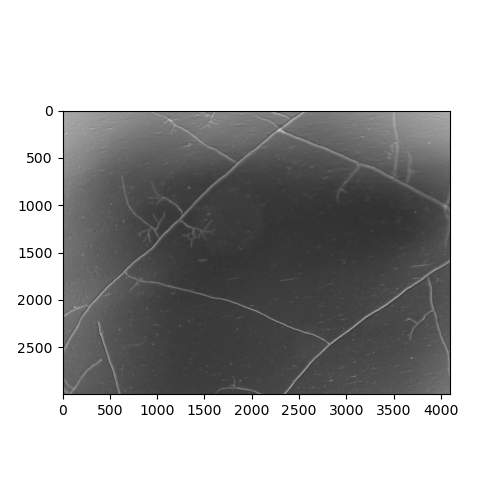

In [51]:
fig = plt.figure(figsize=(5,5))
ax2 = fig.add_subplot(111)
ax2.imshow(-im+255,cmap='gray')

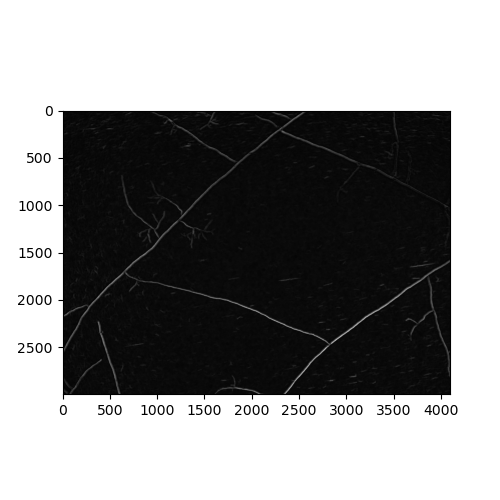

In [53]:
params=[30]
bowled = bowler_hat(-im,16,params)
fig = plt.figure(figsize=(5,5))
ax2 = fig.add_subplot(111)
ax2.imshow(255*bowled,cmap='gray')

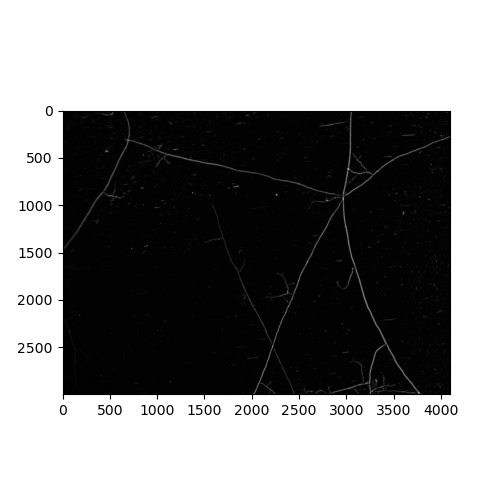

In [8]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
from cv2_rolling_ball import subtract_background_rolling_ball

def plot_result(image, background):
    fig, ax = plt.subplots(nrows=1, ncols=3)

    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Original image')
    ax[0].axis('off')

    ax[1].imshow(background, cmap='gray')
    ax[1].set_title('Background')
    ax[1].axis('off')

    ax[2].imshow(image - background, cmap='gray')
    ax[2].set_title('Result')
    ax[2].axis('off')

    fig.tight_layout()


image = im.copy()

img_back_removed, background = subtract_background_rolling_ball(image, 10, light_background=True,
                                     use_paraboloid=True, do_presmooth=True)

fig = plt.figure(figsize=(5,5))
ax2 = fig.add_subplot(111)
ax2.imshow(-img_back_removed,cmap='gray')

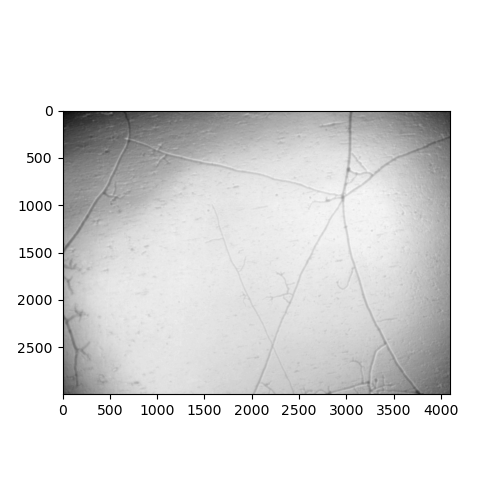

In [9]:
fig = plt.figure(figsize=(5,5))
ax2 = fig.add_subplot(111)
ax2.imshow(background,cmap='gray')

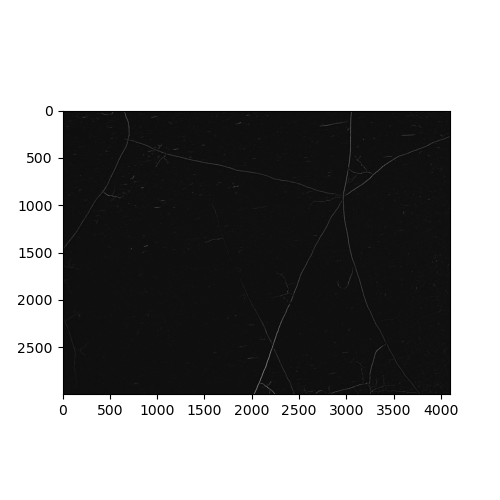

In [10]:
# params=[10]
# bowled1 = bowler_hat(-img_back_removed,12,params)
params=[10]
bowled = bowler_hat(-img_back_removed,12,params)
fig = plt.figure(figsize=(5,5))
ax2 = fig.add_subplot(111)
ax2.imshow(255*bowled,cmap='gray')


In [58]:
filename = 'imtest'
place_save = '/data/temp'
to_smooth = (bowled*255)
# to_smooth = 255-im
imtransformed_path = f'{place_save}/{filename}.tif'
imageio.imsave(imtransformed_path,to_smooth.astype(np.uint8))
# imageio.imsave(imtransformed_path,frangised.astype(np.uint8))

In [59]:
path_anis = os.getenv('HOME')+'/anis_filter/anifilters/bin/ani2D'

In [60]:
# list_args = [[0.1, 7, 0.8, 10, 50],[0.1, 7, 1, 10, 50],[0.1, 7, 1.2, 10, 50]]
list_args = [[0.1, 7, 0.9, 10, 50],[0.1, 15, 0.9, 10, 50],[0.1, 30, 0.9, 10, 50]]

for args in list_args:
    command = [path_anis,imtransformed_path]+args
    command = [str(elem) for elem in command]
    print(r' '.join(command))
    process = subprocess.run(command,cwd = place_save)

/home/ipausers/bisot/anis_filter/anifilters/bin/ani2D /data/temp/imtest.tif 0.1 7 0.9 10 50
image : /data/temp/imtest.tif
mkdir -p imtest_ani-K1s7g9itD10
Image 2D
Computing diffusion tensor
0
1
2
3
4
5
6
7
8
9
update diffusion tensor
10
11
12
13
14
15
16
17
18
19
update diffusion tensor
20
save image
21
22
23
24
25
26
27
28
29
update diffusion tensor
30
31
32
33
34
35
36
37
38
39
update diffusion tensor
40
save image
41
42
43
44
45
46
47
48
49
time elapsed : 27.0547 seconds
  = ~ 0.450912 minutes
/home/ipausers/bisot/anis_filter/anifilters/bin/ani2D /data/temp/imtest.tif 0.1 15 0.9 10 50
image : /data/temp/imtest.tif
mkdir -p imtest_ani-K1s15g9itD10
Image 2D
Computing diffusion tensor
0
1
2
3
4
5
6
7
8
9
update diffusion tensor
10
11
12
13
14
15
16
17
18
19
update diffusion tensor
20
save image
21
22
23
24
25
26
27
28
29
update diffusion tensor
30
31
32
33
34
35
36
37
38
39
update diffusion tensor
40
save image
41
42
43
44
45
46
47
48
49
time elapsed : 27.0181 seconds
  = ~ 0.450302 mi

[0.1, 7, 0.9, 10, 50]
[0.1, 15, 0.9, 10, 50]
[0.1, 30, 0.9, 10, 50]


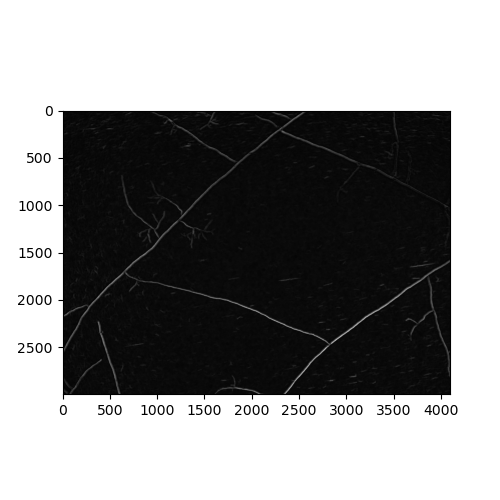

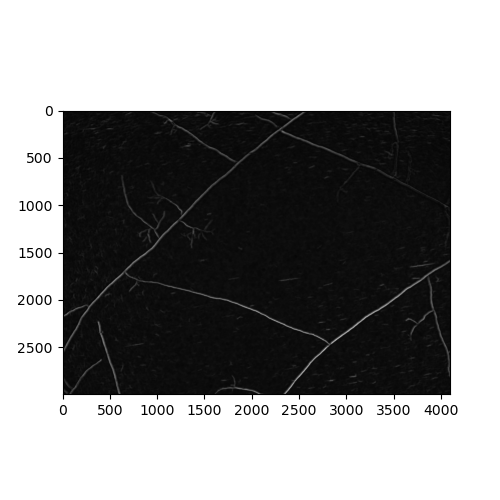

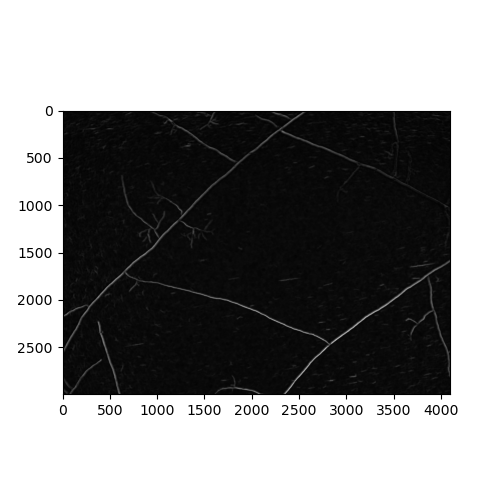

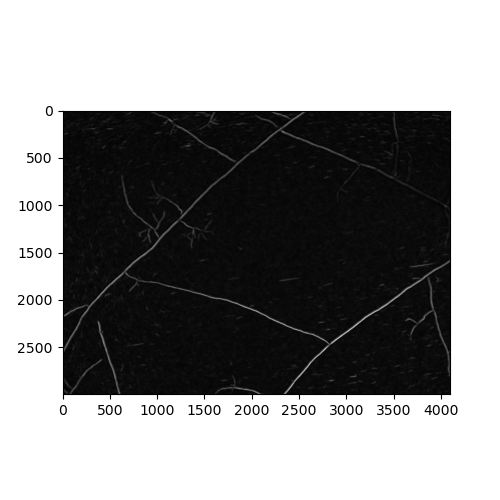

In [61]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.imshow(bowled,cmap='gray')
for args in list_args:
    foldname = f'{filename}_ani-K{int(args[0]*10)}s{args[1]}g{int(args[2]*10)}itD{args[3]}'
    imname = foldname+f'/{foldname}it{args[4]}.tif'
    path_modif = place_save +"/"+ imname
    im2 = imageio.imread(path_modif)
    print(args)
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    ax.imshow(im2,cmap='gray')
    # bowled = bowler_hat(im2,12,[10])
    # fig = plt.figure(figsize=(5,5))
    # ax = fig.add_subplot(111)
    # ax.imshow(bowled*255,cmap='gray')
    # break

In [68]:
values = []
percentiles = np.linspace(80,98,25)
for percentile in percentiles:
    low = np.percentile(im2, percentile)
    high = np.percentile(im2, 99.8)
    # transformed = -img+255
    transformed = im2

    hyst = filters.apply_hysteresis_threshold(transformed, low, high)
    values.append(np.sum(hyst))

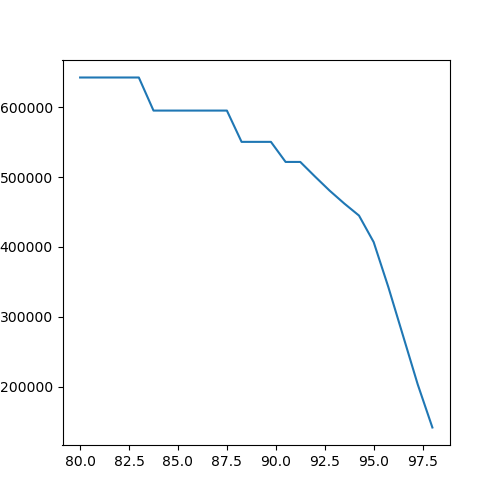

In [69]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.plot(percentiles,values)

In [ ]:
np.lins

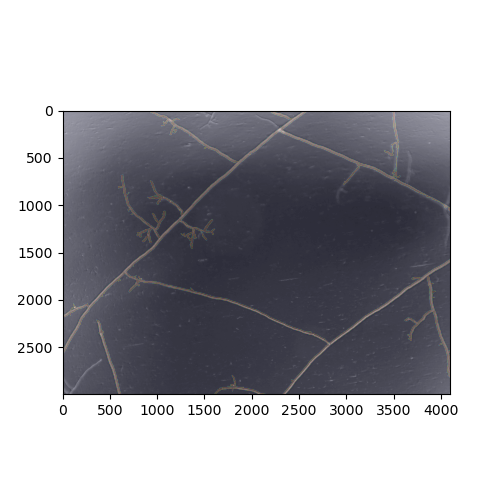

In [67]:
low = np.percentile(im2, 91)
high = np.percentile(im2, 99.8)
# transformed = -img+255
transformed = im2

hyst = filters.apply_hysteresis_threshold(transformed, low, high)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.imshow(-im,cmap='gray')
ax.imshow(hyst,alpha = 0.1,cmap='jet')

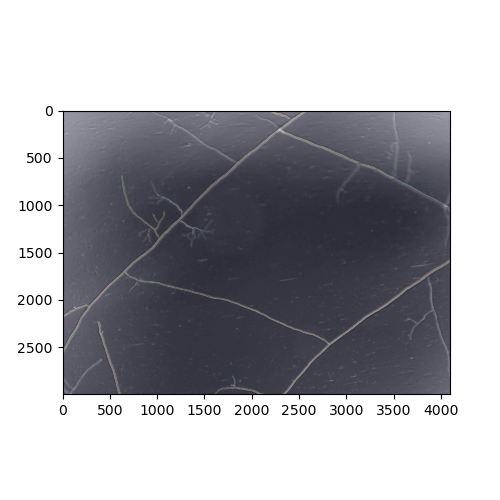

In [65]:
low = np.percentile(im2, 96.5)
high = np.percentile(im2, 99.8)
# transformed = -img+255
transformed = bowled*255

hyst = filters.apply_hysteresis_threshold(transformed, low, high)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.imshow(-im,cmap='gray')
ax.imshow(hyst,alpha = 0.1,cmap='jet')

In [16]:
kernel = np.ones((3,3),np.uint8)
dilation = cv.dilate(hyst.astype(np.uint8) * 255,kernel,iterations = 1)
for i in range(3):
    dilation=cv.erode(dilation.astype(np.uint8) * 255,kernel,iterations = 1)
    dilation = cv.dilate(dilation.astype(np.uint8) * 255,kernel,iterations = 1)
dilated = dilation>0
nb_components, output, stats, centroids = cv.connectedComponentsWithStats(dilated.astype(np.uint8), connectivity=8)
#connectedComponentswithStats yields every seperated component with information on each of them, such as size
#the following part is just taking out the background which is also considered a component, but most of the time we don't want that.
sizes = stats[1:, -1]; nb_components = nb_components - 1

# minimum size of particles we want to keep (number of pixels)
#here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever
min_size = 4000  

#your answer image
img_f = np.zeros((dilated.shape))
#for every component in the image, you keep it only if it's above min_size
for i in range(0, nb_components):
    if sizes[i] >= min_size:
        img_f[output == i + 1] = 1
skeletonized = cv.ximgproc.thinning(np.array(255*img_f,dtype=np.uint8))


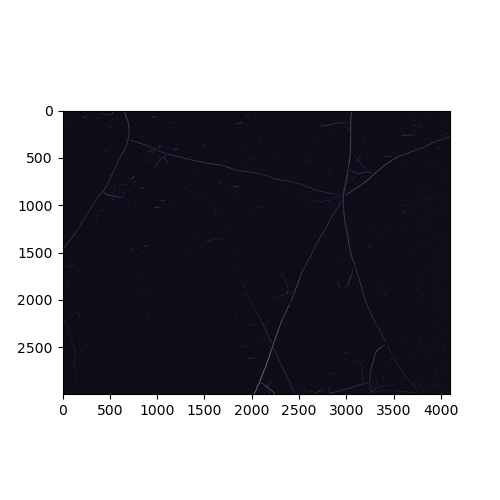

In [17]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.imshow(im2,cmap='gray')
ax.imshow(skeletonized,cmap='jet',alpha =0.1)